In [ ]:
# dev options
from tensorflow.compat.v1 import RunOptions
RunOptions(report_tensor_allocations_upon_oom = True)

In [166]:
# linux version
!lsb_release -a
print("---")
# gpu info
!nvidia-smi

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic
---
Wed Mar 23 14:06:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    278MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+--------------

### install package

In [ ]:
#!pip install git+https://github.com/alecsharpie/cassava_farmer.git --no-cache

# Google Colab Authentication

In [3]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!cat adc.json

# Gcloud CLI Authentication

In [4]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=d6k2EoZ74g8lp9J0785b3OUqrmZbN8&prompt=consent&access_type=offline&code_challenge=TdjQGaB1X5-a862x0otRTWVb3N8OoHKhxC55QMk1Ob0&code_challenge_method=S256

Enter verification code: 4/1AX4XfWij30-eUYQUv7nxNUHjNTESVV3QBHyAVDK-FvbHHnbgP3DbtWPvUn8

You are now logged in as [alecsharpie@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [5]:
!gcloud config set project alecsharpie
!gcloud config list

Updated property [core/project].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
[core]
account = alecsharpie@gmail.com
project = alecsharpie

Your active configuration is: [default]


# Get all data before training and directly as images using Gfile

In [185]:
import os
import tensorflow as tf
from tensorflow import strings
from tensorflow.image import resize
from tensorflow.io import decode_image, gfile
from tensorflow.data import Dataset
from tensorflow import py_function
from tensorflow.data import AUTOTUNE

def get_label(file_path):
    label_map = {
    'cassava_bacterial_blight': 0,
    'cassava_brown_streak_disease': 1,
    'cassava_green_mottle': 2,
    'cassava_mosaic_disease': 3,
    'healthy': 4
    }
    # Convert the path to a the containing folder name as a string
    class_name = strings.split(file_path, os.path.sep)[-2].numpy().decode("utf-8")
    # Swap out the label for its id
    return label_map[class_name]

def get_img(file_path):
    # Read in the file from google cloud storage
    jpg_file = gfile.GFile(file_path.decode('utf-8'), 'br').read()
    # Convert the jpg string to a 3D uint8 tensor
    img = decode_image(jpg_file, channels=3)
    # Resize and rescale image to the desired size
    return resize(img, [512, 512]) / 255.0

def get_training_example(file_path):
    # get the image as a tensor from the filepath
    img = get_img(file_path.numpy())
    # get the target from the filepath
    label = get_label(file_path.numpy())
    return img, label

def get_dataset_gfile(file_glob):
    # create dataset generator of file paths
    list_ds = Dataset.list_files(file_glob)
    # split the data into train and validation sets
    val_size = int(list_ds.cardinality().numpy() * 0.8)
    list_train_ds = list_ds.skip(val_size)
    list_val_ds = list_ds.take(val_size)

    # convert file paths into labelled image data 
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    train_ds = list_train_ds.map(lambda x: py_function(get_training_example, [x], [tf.float32, tf.int8]), num_parallel_calls=AUTOTUNE)
    val_ds = list_val_ds.map(lambda x: py_function(get_training_example, [x], [tf.float32, tf.int8]), num_parallel_calls=AUTOTUNE)

    return train_ds, val_ds


In [186]:
train_ds, val_ds = get_dataset_gfile('gs://image-datasets-alecsharpie/cassava_farmer/train_images_small/*/*.jpg')

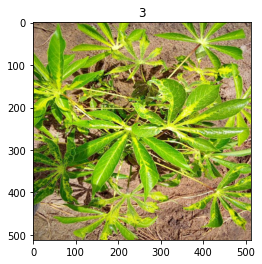

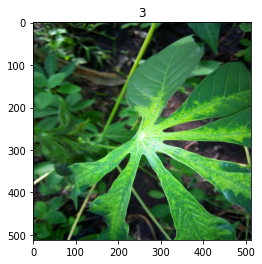

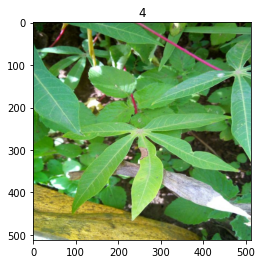

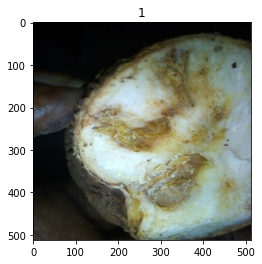

In [191]:
for X, y in train_ds.take(4).as_numpy_iterator():
  #print(get_label(file_name))
  #print(get_img(file_name))
  plt.imshow(X)
  plt.title(f'{y}')
  plt.show()

# Get data by mounting using gcsfuse

 

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k
OK
63 packages can be upgraded. Run 'apt list --upgradable' to see them.
^C


In [ ]:
!mkdir gcs_bucket
!gcsfuse --implicit-dirs image-datasets-alecsharpie gcs_bucket
!ls gcs_bucket

2022/03/18 06:20:46.033365 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/gcs_bucket
2022/03/18 06:20:46.045125 Opening GCS connection...
2022/03/18 06:20:46.280047 Mounting file system "image-datasets-alecsharpie"...
2022/03/18 06:20:46.308960 File system has been successfully mounted.


In [179]:
from tensorflow.keras.utils import image_dataset_from_directory

def get_dataset_gcsfuse(
    batch_size,
    train_path='raw_data'
):


    train_ds = image_dataset_from_directory(
        train_path,
        batch_size=batch_size,
        subset='training',
        validation_split=.20,
        seed=12,
        image_size=(512, 512),
        shuffle = True
    )

    train_ds = train_ds.repeat()

    val_ds = image_dataset_from_directory(train_path,
                                          batch_size=batch_size,
                                          subset='validation',
                                          validation_split=.20,
                                          seed=12,
                                          image_size=(512, 512),
                                          shuffle = True)

    val_ds = val_ds.repeat()

    return train_ds, val_ds


In [ ]:
# print out some data with labels
import matplotlib.pyplot as plt

for batch in train_ds.take(1).as_numpy_iterator():
  print('X shape: ', batch[0].shape)
  print('X min, max: ', np.min(batch[0]), np.max(batch[0]))
  fig, axes = plt.subplots(3, 3 , figsize = (15, 15))
  for x, y, ax in zip(batch[0], batch[1], axes.flat):
    ax.imshow(x)
    ax.set_title(y)

# Build Model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy


#from tensorflow.config import run_functions_eagerly

#from google.cloud import storage


def build_aug_eff_model(input_shape):

    augmentation = Sequential([
        layers.RandomContrast(0.1),
        #layers.RandomRotation(40),
        #layers.RandomTranslation(0, 0.1),
        #layers.RandomTranslation(0.1, 0),
        #layers.RandomZoom(0.2, 0.2),
        layers.RandomFlip(mode="horizontal")
    ])

    dummy_input = layers.Input(shape=input_shape)

    topless_efficient_net = EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=dummy_input,
                                        pooling='max')

    aug_eff_model = Sequential([
        #layers.Resizing(512, 512),
        augmentation,
        topless_efficient_net,
        layers.Dense(120, activation = 'tanh'),
        layers.Dropout(0.2),
        layers.Dense(12, activation = 'tanh'),
        layers.Dropout(0.3),
        layers.Dense(5, activation='softmax')
    ])

    #top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
    #top3_acc.__name__ = 'top3_acc'


    aug_eff_model.compile(optimizer=Adam(0.0000005),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3, name='top_k_acc')])
                        #run_eagerly=True)

    aug_eff_model.build((None, 512, 512, 3))

    aug_eff_model.layers[0].trainable = False

    # for layer in aug_eff_model.layers:
    #   layer.trainable = False

    # for layer in aug_eff_model.layers:
    #   print(len(layer.trainable_weights))
    #   print(len(layer.non_trainable_weights))

    aug_eff_model.summary()

    return aug_eff_model

In [ ]:
# import data and calculate sizes and count weights

import numpy as np

batch_size = 24

train_ds, val_ds = get_dataset_gcsfuse(batch_size, 'gcs_bucket/cassava_farmer/train_images')

steps_per_epoch = train_ds.cardinality().numpy() // batch_size
validation_steps = val_ds.cardinality().numpy() // batch_size

# steps_per_epoch = 10
# validation_steps = 3

print('steps_per_epoch: ', steps_per_epoch)
print('validation_steps: ', validation_steps)



Found 18190 files belonging to 5 classes.
Using 14552 files for training.
Found 18190 files belonging to 5 classes.
Using 3638 files for validation.
steps_per_epoch:  25
validation_steps:  6


In [ ]:
count_map = {
    0: 1087,
    1: 2189,
    2: 2386,
    3: 13158,
    4: 2577
}

# balance dataset
avg_count = np.array(list(count_map.values())).mean()
class_weights = {k: (1 / v) * avg_count for k, v in count_map.items()}

# Train Model

In [ ]:
from tensorflow.keras.callbacks import Callback
class PlotLearningCurve(Callback):

    def __init__(self, interval = 32):
        super(PlotLearningCurve, self).__init__()
        self.interval = interval
        self.loss_history = {'loss' : [], 'val_loss' : []}

    def on_epoch_end(self, epoch, logs=None):
        self.loss_history['loss'].append(logs['loss'])
        if logs['val_loss']:
            self.loss_history['val_loss'].append(logs['val_loss'])
        if epoch > 0 and epoch % self.interval == 0:
            plt.plot(self.loss_history['loss'], label = 'Train loss')
            if logs['val_loss']:
                plt.plot(self.loss_history['val_loss'], label = 'Val loss')
            plt.title('Loss learning curve')
            plt.legend()
            plt.show();


In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from zipfile import ZipFile
from google.colab import files

class ModelCheckpointDownload(Callback):

  def __init__(self, interval, filepath, monitor, save_best_only):
        super(ModelCheckpointDownload, self).__init__()
        self.interval = interval
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best = np.inf

  def on_epoch_end(self, epoch, logs=None):
      if epoch > 0 and epoch % self.interval == 0:
          current = logs[self.monitor]
          if self.save_best_only:
              if np.less(current, self.best):
                  self.best = current
                  self.model.save(self.filepath)
          else:
              self.model.save(self.filepath)
          print(f'Zipping to {self.filepath}.zip')
          with ZipFile(f'{self.filepath}.zip', 'w') as myzip:
              myzip.write(self.filepath)
              files.download(f'{self.filepath}.zip')
          print('Download Started!')


In [ ]:
#!pip install wandb

In [ ]:
#import wandb

#wandb.init(project="cassava", entity="alecsharpie")


In [ ]:
#from cassava_farmer.data import get_image_generator_local
#from cassava_farmer.model import build_aug_eff_model, save_model_to_gcp
#from cassava_farmer.gcs import storage_upload_file, storage_upload_folder

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np


es = EarlyStopping(patience=100, restore_best_weights = True)

# checkpoint = ModelCheckpointDownload(filepath = 'models/aug_eff_model', 
#                                      interval = 300, 
#                                      monitor = 'val_loss', 
#                                      save_best_only = True)

# wandb_callback = wandb.keras.WandbCallback(log_weights=True)

model = build_aug_eff_model((512, 512, 3))
#model = build_model()
#model = build_simple_model()


history = model.fit(
  train_ds,
  epochs=500,
  #batch_size=batch_size,
  class_weight = class_weights,
  steps_per_epoch=steps_per_epoch,
  validation_data=val_ds,
  validation_steps=validation_steps,
  validation_batch_size=batch_size,
  callbacks=[es, PlotLearningCurve(32)]
  ).history


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 120)               153720    
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_7 (Dense)             (None, 12)                1452      
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.title(f'bs:{str(batch_size)} ')
plt.legend();

#save learning curve 
plt.savefig('learning_curve.png')

In [ ]:
!mkdir history
!mkdir models

In [ ]:
import json
from datetime import datetime
from google.colab import files

history_file_name = f'history/{datetime.now().strftime("history_%Y-%m-%d_%H-%M-%S")}.json'
out_file = open(history_file_name, "w")
json.dump(history, out_file, indent="")
out_file.close()
files.download(f"/content/{history_file_name}")
#storage_upload_file(history_file_name)

# save
model.save('models/aug_eff_model')
# save
!zip -r /content/models/eff_model_colab.zip /content/models/aug_eff_model
# download
files.download("/content/models/eff_model_colab.zip")
#storage_upload_folder('models/aug_eff_model_test')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'], label = 'train')
plt.plot(history['val_accuracy'], label = 'val')
plt.title(f'')
plt.legend();
plt.savefig('learning_curve_accuracy.png')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(train_ds.take(20))

y_pred

In [ ]:
for example in train_ds.take(1).as_numpy_iterator():
  print('X: ', example[0].shape)
  print('Y: ', example[1].shape)

In [ ]:
#classification_report(y_pred, )

In [ ]:
print('max train accuracy', max(history['accuracy']))
print('max val accuracy', max(history['val_accuracy']))

In [ ]:
# from cassava_farmer.trainer import Trainer
# trainer = Trainer('colab')
# trainer.train(data_path = 'gcs_bucket/cassava_farmer/train_images')

In [ ]:
# # load previous history
# import json

# history = json.load(open('/content/history/history_2022-02-27_16-43-50'))

# history

In [ ]:
label_map = {
    '0': 'cassava_bacterial_blight', #1087
    '1': 'cassava_brown_streak_disease', #2189
    '2': 'cassava_green_mottle', #2386
    '3': 'cassava_mosaic_disease', #13158
    '4': 'healthy' #2577
}

# load model back in

In [ ]:
# !unzip eff_model.zip

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import image_dataset_from_directory

# eff_model = load_model('eff_model')


# from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy

# eff_model.compile(
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3, name='top_k_acc')]
#             )


# # val_ds = image_dataset_from_directory('gcs_bucket/cassava_farmer/train_images',
# #                                       batch_size=24,
# #                                       subset='validation',
# #                                       validation_split=.20,
# #                                       seed=12,
# #                                       image_size=(512, 512),
# #                                       shuffle = True)

# test_ds = image_dataset_from_directory('gcs_bucket/cassava_farmer/test_images',
#                                       batch_size=24,
#                                       image_size=(512, 512),
#                                       shuffle = True)


# result = eff_model.evaluate(test_ds)
# print(result)